In [1]:
#circular inference model
import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
# import pystan
%matplotlib inline

In [2]:
def function(L,w):
    f = np.log((w*np.exp(L)+1-w) / ((1-w)*np.exp(L)+w))
    return f

In [3]:
def circular_inference(prior, left_lik,right_lik,param):

    pa1 = param[0]
    pa2 = param[1]
    pa3 = param[2]
    pa4 = param[3]

    #prior logit
    Cp = prior/100
    Fp = 1 - prior/100
    Lp = np.log(Cp/Fp)
    aplp = pa3*Lp
    Faplpwp = function(aplp,pa1)

    #likelihood logit
    Cr = left_lik/100
    Cr_oppo = right_lik/100
    Ls = np.log(Cr/Cr_oppo)
    asls = pa4*Ls
    Faslsws = function(asls,pa2)

    Lc = function(Ls+Faplpwp+Faslsws,pa2) + function(Lp+Faslsws+Faplpwp,pa1)
    pred_c = np.exp(Lc)/(1+np.exp(Lc))

    pred_c = np.clip(pred_c,0.018,0.982)
    

    return pred_c, Lc

In [4]:
data, image_data = preprocessing.preprocess()

In [5]:
likelihood_dir = # likelihood directory 
like_data = pd.read_csv(likelihood_dir)

# print(like_data)
like_data['categ1_ave']
for i in range(1,101):
    data.loc[data['imgseq']==i,'correct_image'] = like_data.loc[like_data['im_number']==i,'categ1_ave'].values[0]
    data.loc[data['imgseq']==i,'false_image'] = like_data.loc[like_data['im_number']==i,'categ2_ave'].values[0]
    
# print(like_data.loc[like_data['im_number']==1,'categ1_ave'].values[0])
    
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

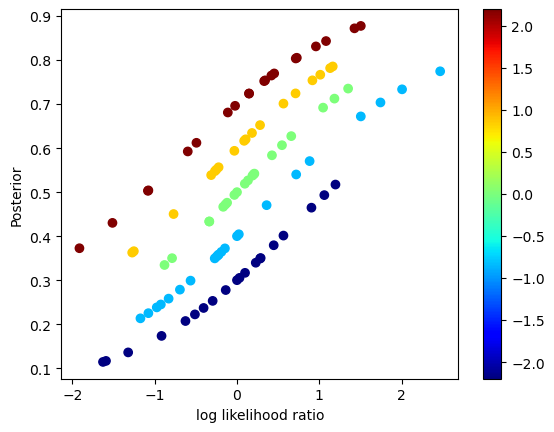

In [6]:
sub_list = []
# number_sub = 21
number_sub=1
sigma = 0
for subject_number in range(number_sub):
#     print(subject_number)
    sub_data = data[data['subject']==subject_number]
    prior_list = np.zeros(100)
    left_like_lis = np.zeros(100)
    right_like_lis = np.zeros(100)
    c_list = np.zeros(100)

    for trial in range(100):
        prior_list[trial] = sub_data.at[(100*subject_number)+trial,'prior']
        
        #likelihood depends on the corloc
        if sub_data.at[(100*subject_number)+trial,'corloc']==1:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
        elif sub_data.at[(100*subject_number)+trial,'corloc']==2:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']

        c_list[trial] = sub_data.at[(100*subject_number)+trial,'posterior']

    prior_list = [n/100 for n in prior_list]
    left_like_lis = [n/100 for n in left_like_lis]
    right_like_lis = [n/100 for n in right_like_lis]
    c_list = [1 if c==0 else c for c in c_list]
    c_list = [99 if c==100 else c for c in c_list]
    c_list = [n/100 for n in c_list]

    wp = 0.75
    ws = 0.9
    alpha_p = 0
    alpha_s = 0
    params = [wp,ws,alpha_p,alpha_s]
    c_estimated = np.zeros(100)
    Lc = np.zeros(100)
    for t in range(100):
        c_estimated[t], Lc[t] = circular_inference(prior_list[t]*100,left_like_lis[t]*100,right_like_lis[t]*100,params)
    
#     plt.plot(likelihood_list,c_estimated)

    prior_ratio = [np.log(prior/(1-prior)) for prior in prior_list]
    like_ratio = [np.log(left/right) for left, right in zip(left_like_lis,right_like_lis)]

    cm = plt.cm.get_cmap('jet')
    plt.scatter(like_ratio,c_estimated,c=prior_ratio,cmap=cm)
    plt.colorbar()
    plt.xlabel('log likelihood ratio')
    plt.ylabel('Posterior')
    plt.show()

Text(0, 0.5, 'Posterior')

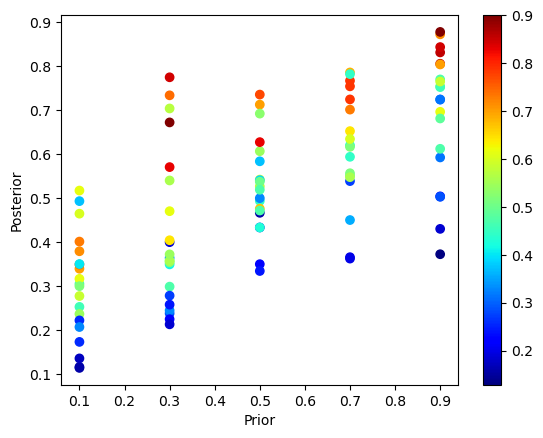

In [7]:
cm = plt.cm.get_cmap('jet')
plt.scatter(prior_list,c_estimated,c=left_like_lis,cmap=cm)
plt.colorbar()
plt.xlabel('Prior')
plt.ylabel('Posterior')

In [8]:
data['Log_likelihood_for_left'] = data.apply(lambda x: np.log(x['correct_image'] / x['false_image']) if x['corloc'] == 1 else np.log(x['false_image'] / x['correct_image']), axis=1)
data['Log_likelihood'] = data.apply(lambda x: np.log(x['correct_image'] / x['false_image']), axis=1)

0.0


/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_82404/4066779660.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2d.replace(0, float('nan'), inplace=True)


Text(50.722222222222214, 0.5, 'Log Likelihood')

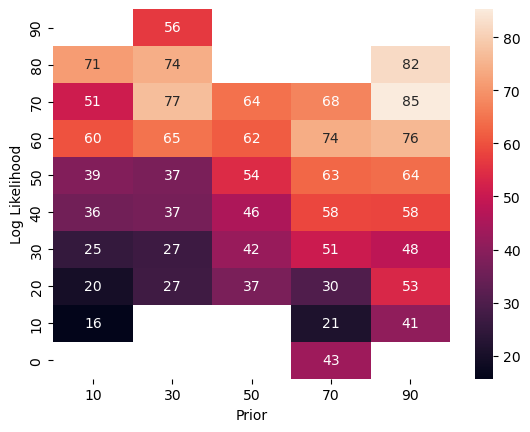

In [96]:
import seaborn as sns
# print(prior_ratio)
# print(like_ratio)

# plt.plot(like_ratio)


data['Log_likelihood_for_left']

step = (np.max(data['Log_likelihood_for_left'])-np.min(data['Log_likelihood_for_left']))/10

for i in range(10):
    data.loc[data['Log_likelihood_for_left'] >i*step+np.min(data['Log_likelihood_for_left']), 'Likelihood'] = i*10


print(np.min(data['Likelihood']))

data2d = pd.DataFrame(columns=[10,30,50,70,90],index=[0,10,20,30,40,50,60,70,80,90])
for pri in [10,30,50,70,90]:
    for lik in [0,10,20,30,40,50,60,70,80,90]:
        temp = data[data['prior']==pri]
        if lik in temp['Likelihood'].values:
            temp2 = temp[temp['Likelihood']==lik]
            data2d.loc[lik,pri] = np.mean(temp2['posterior'])
        else:
            data2d.loc[lik,pri] = 0
data2d.replace(0, float('nan'), inplace=True)
ax = sns.heatmap(data2d, annot=True)
ax.invert_yaxis()
plt.xlabel('Prior')
plt.ylabel('Log Likelihood')
